In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

## Player Analysis

In [2]:
player_df = pd.read_csv("csv/common_player_info.csv")

### Origin
Country, school or the state (if the player is a US citizen)

In [3]:
def make_hist(df, col, title):
    plt.hist(df[col])
    plt.title(title)

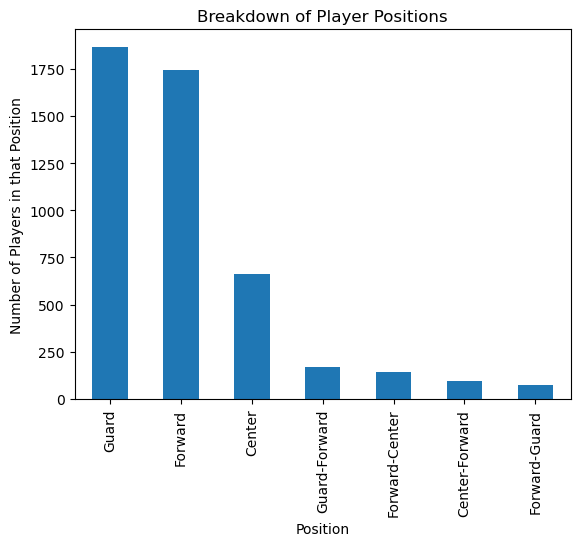

In [4]:
player_df['position'].value_counts().plot(kind='bar')
plt.xlabel("Position")
plt.ylabel("Number of Players in that Position")
plt.title("Breakdown of Player Positions")
plt.show()

In [5]:
def convert_height_to_cm(height):
    if type(height) == float:
        return 0
    feet, inches = height.split('-')
    inches = int(inches)
    inches += int(feet) * 12
    h_cm = round(inches * 2.54, 1)
    return h_cm

In [6]:
# convert height to cm for players with non-null height
player_df['height_cm'] = player_df['height'].apply(convert_height_to_cm)

# impute mean height for players with 0 height_cm
player_df['height_cm'] = player_df['height_cm'].replace(0, player_df['height_cm'].mean())

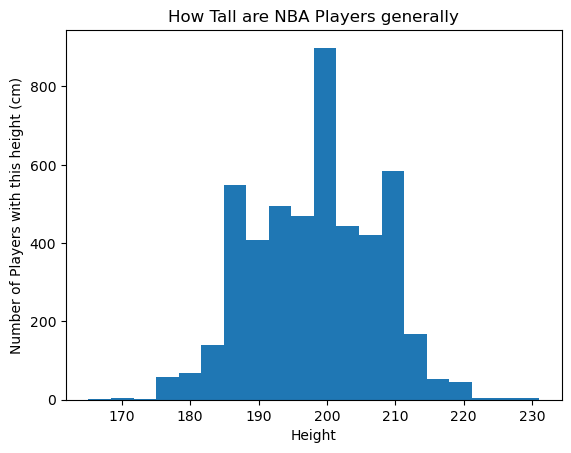

In [7]:
player_df['height_cm'].plot.hist(bins=20)
plt.xlabel("Height")
plt.ylabel("Number of Players with this height (cm)")
plt.title("How Tall are NBA Players generally")
plt.show()

In [8]:
# convert weight to kg for players with non-null weight
player_df['weight_kg'] = player_df['weight'].apply(lambda x: round(x * 0.453592, 1))

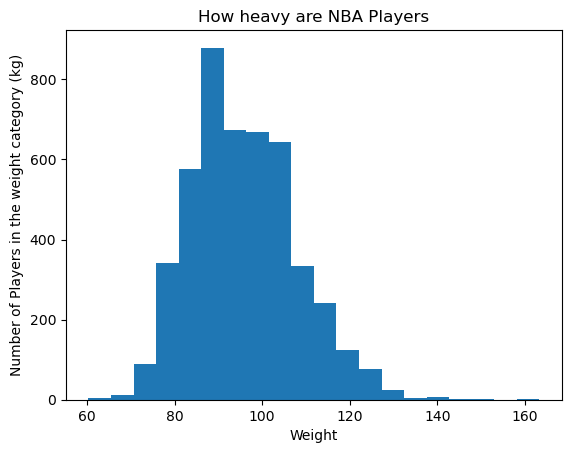

In [9]:
player_df['weight_kg'].plot.hist(bins=20)
plt.xlabel("Weight")
plt.ylabel("Number of Players in the weight category (kg)")
plt.title("How heavy are NBA Players")
plt.show()

### Top 5 Schools producing the most number of NBA Players

In [10]:
player_df['school'].value_counts(ascending=False)[:5]

Kentucky          115
UCLA               96
Duke               92
North Carolina     87
Kansas             76
Name: school, dtype: int64

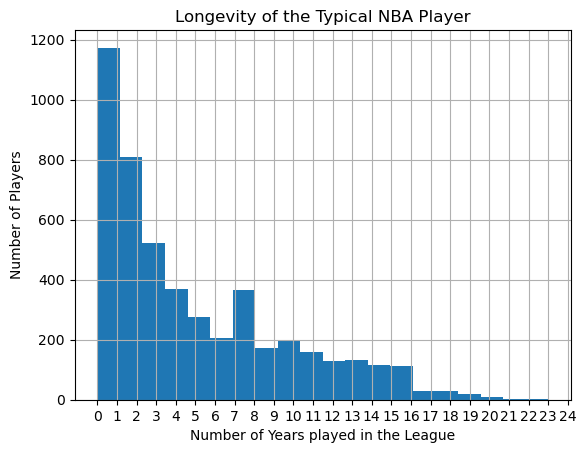

In [11]:
player_df['season_exp'].hist(bins=20)
plt.xticks([i for i in range(25)])
plt.xlabel("Number of Years played in the League")
plt.ylabel("Number of Players")
plt.title("Longevity of the Typical NBA Player")
plt.show()

### Top 5 Countries with the most number of NBA Players

In [12]:
player_df['country'].value_counts(ascending=False)[:5]

USA          4361
Canada         48
France         39
Serbia         31
Australia      25
Name: country, dtype: int64

## Draft Related Analyses

### Which Teams Receive the Most Amount of Help from the Draft

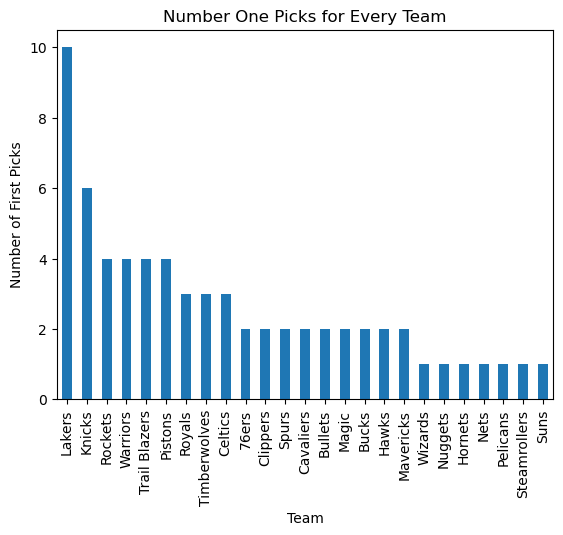

In [13]:
player_df[player_df['draft_number']=="1"]['team_name'].value_counts().plot(kind='bar')
plt.xlabel("Team")
plt.ylabel("Number of First Picks")
plt.title("Number One Picks for Every Team")
plt.show()

# Players & Teams Analysis

In [14]:
# raptor_df_modern = pd.read_csv("nba-raptor/modern_RAPTOR_by_team.csv")
raptor_df_historical = pd.read_csv("nba-raptor/historical_RAPTOR_by_team.csv")
raptor_df_latest = pd.read_csv("nba-raptor/latest_RAPTOR_by_team.csv")
raptor_df_latest = raptor_df_latest[raptor_df_historical.columns]
raptor_df = pd.concat([raptor_df_historical, raptor_df_latest])
# make it so that PO comes after RS
raptor_df = raptor_df \
    .sort_values(by=['player_id', 'season','season_type'], ascending=[1,1,0]) \
    .groupby(['player_id', 'season']) \
    .head(5) # max number of teams a player can play for in a season

In [15]:
# get all rows of player with player_id
def get_player_rows(player_id):
    return raptor_df[raptor_df['player_id'] == player_id]

# get a list of all teams a player has played for
def get_team_list(player_name):
    team_list = []
    for i in range(len(raptor_df)):
        if raptor_df.iloc[i]['player_name'] == player_name:
            team_list.append(raptor_df.iloc[i][['season', 'season_type', 'team']].to_dict())
    return team_list

def get_player_id_by_name(player_name):
    return raptor_df[raptor_df['player_name'] == player_name]['player_id'].unique()[0]

In [16]:
def check_po_team_count():
    # check if there is any PO season with more than 1 team
    df = raptor_df.groupby(['player_id', 'season', 'season_type'])["team"].count().reset_index()
    return df.loc[(df["team"] > 1) & (df["season_type"] == "PO")]

check_po_team_count()

,player_id,season,season_type,team


In [17]:
def sort_teams(player_id):
    """General rules:
    In each season, there is a regular season (RS) and a playoff season (PO).
    In the RS, a player can play for multiple teams.
    In the PO, a player can only play for at most one team.
    We know that teams in all POs are sorted correctly.
    Problems might occur when there is more than one team in the RS.
    """
    player_df = get_player_rows(player_id)
    player_df = sort_teams_rule1(player_df)
    player_df = sort_teams_rule2(player_df)
    # note that if no rules apply, then the order is alphabetical
    return player_df


def check_rule1(season_df):
    """Assert that rule 1 is satisfied"""
    rs_df = season_df[season_df["season_type"] == "RS"]
    po_df = season_df[season_df["season_type"] == "PO"]
    if len(rs_df) <= 1:
        # if there is only one team in the RS season or if player did not play the RS season
        # then the season is sorted correctly
        return True
    if "PO" not in season_df["season_type"].unique():
        # if there is no PO season in the season, then rule 1 is satisfied
        return True
    if rs_df.iloc[-1]["team"] == po_df.iloc[0]["team"]:
        # if the last team in the RS season is the same as the PO team, then the season is sorted correctly
        return True
    return False


def sort_teams_rule1(player_df):
    """Rule 1:
    If there is a PO season in a season, and if the RS season has more than 1 team,
    then one of the teams in the RS season might be the same as the PO team.
    If this is the case, then we swap the rows in the RS season such that the last team in RS matches the PO team.
    """
    all_seasons = player_df["season"].unique()
    season_dfs = []
    for season in all_seasons:
        season_df = player_df[player_df["season"] == season]
        rs_df = season_df[season_df["season_type"] == "RS"]
        po_df = season_df[season_df["season_type"] == "PO"]
        if not check_rule1(season_df):
            po_team = po_df.iloc[0]["team"]
            match_mask = rs_df["team"] == po_team
            rs_team_match = rs_df[match_mask]
            rs_team_no_match = rs_df[~match_mask]
            rs_df = pd.concat([rs_team_no_match, rs_team_match])
        season_df = pd.concat([rs_df, po_df])
        season_dfs.append(season_df)
    player_df = pd.concat(season_dfs)
    return player_df


def sort_teams_rule2(player_df):
    """Rule 2:
    If two consecutive seasons have a common team, then the last team in the first season
    should be the same as the first team in the second season.
    Only check this if rule1 fails.
    """
    all_seasons = player_df["season"].unique()
    # first season is assumed sorted thanks to rule1
    season_dfs = [player_df[player_df["season"] == all_seasons[0]]]
    for i in range(len(all_seasons) - 1):
        season1 = all_seasons[i]
        season2 = all_seasons[i + 1]
        season1_df = player_df[player_df["season"] == season1]
        season2_df = player_df[player_df["season"] == season2]
        season1_last_team = season1_df["team"].values[-1]
        season2_first_team = season2_df["team"].values[0]
        if season1_last_team != season2_first_team:
            # don't do anything if season2_df follows rule 1
            if check_rule1(season2_df):
                season_dfs.append(season2_df)
                continue
            # swap the rows in season2_df such that the last team in season1 matches the first team in season2
            match_mask = season2_df["team"] == season1_last_team
            season2_team_match = season2_df[match_mask]
            season2_team_no_match = season2_df[~match_mask]
            season2_df = pd.concat([season2_team_match, season2_team_no_match])
        season_dfs.append(season2_df)
    player_df = pd.concat(season_dfs)
    return player_df


def check_rs_po_order(player_df):
    """Check if there is a PO season, then it must be the last season in each season"""
    all_seasons = player_df["season"].unique()
    for season in all_seasons:
        season_df = player_df[player_df["season"] == season]
        if "PO" in season_df["season_type"].unique():
            if season_df["season_type"].values[-1] != "PO":
                raise Exception(f"PO season is not the last season in season {season} for player {player_df['player_id'].values[0]}")
    
def check_season_order(player_df):
    """Verify that the seasons are in chronological order"""
    all_seasons = player_df["season"].unique()
    for i in range(len(all_seasons) - 1):
        season1 = all_seasons[i]
        season2 = all_seasons[i + 1]
        if season1 >= season2:
            raise Exception(f"Season {season1} is not before season {season2} for player {player_df['player_id'].values[0]}")

In [18]:
player_ids = raptor_df["player_id"].unique()
player_dfs = []
for player_id in player_ids:
    try:
        player_df = sort_teams(player_id)
        check_rs_po_order(player_df)
        check_season_order(player_df)
        player_dfs.append(player_df)
    except Exception as e:
        print(player_id)
        print(e)
player_dfs = pd.concat(player_dfs)

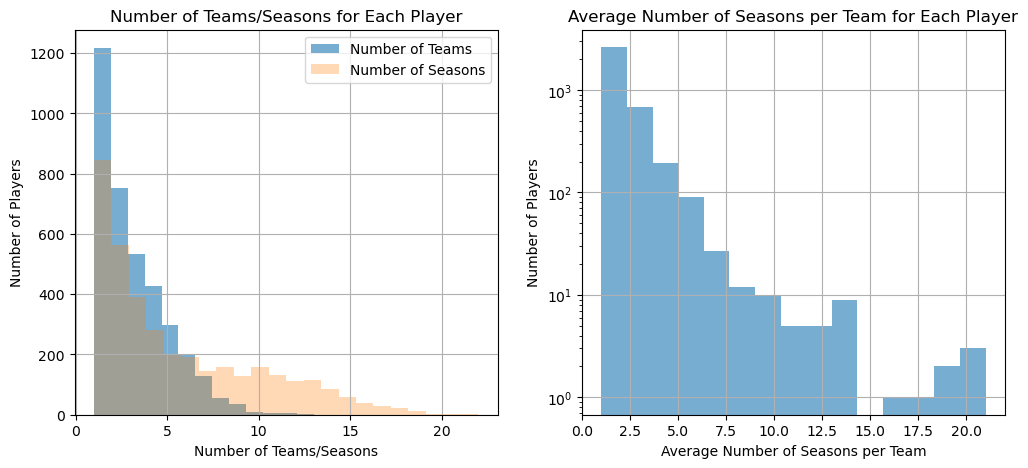

In [19]:
# plot distribution of number of teams in a player's career
team_counts = player_dfs.groupby("player_id")["team"].nunique()
max_team_count = team_counts.max()

season_counts = player_dfs.groupby("player_id")["season"].nunique()
max_season_count = season_counts.max()

def get_team_season_count(player_df):
    team_season_counts = player_df.groupby("team")["season"].nunique()
    return team_season_counts.mean()

team_season_counts = player_dfs.groupby("player_id").apply(get_team_season_count)

# plot both counts on the same plot
fig, axs = plt.subplots(1,2, figsize=(12,5))
team_counts.hist(bins=max_team_count, ax=axs[0], alpha=0.6, label="Number of Teams")
season_counts.hist(bins=max_season_count, ax=axs[0], alpha=0.3, label="Number of Seasons")
team_season_counts.hist(bins=15, ax=axs[1], alpha=0.6, label="Number of Seasons/Team")
axs[0].legend()
axs[0].set_xlabel("Number of Teams/Seasons")
axs[0].set_ylabel("Number of Players")
axs[0].set_title("Number of Teams/Seasons for Each Player")
axs[1].set_yscale("log")
axs[1].set_xlabel("Average Number of Seasons per Team")
axs[1].set_ylabel("Number of Players")
axs[1].set_title("Average Number of Seasons per Team for Each Player")
plt.show()

In [20]:
# teams_df = pd.read_csv("csv/team.csv")
# # Define a dictionary mapping state names to abbreviations
# state_abbr = {'Alabama': 'AL', 'Alaska': 'AK', 'Arizona': 'AZ', 'Arkansas': 'AR', 'California': 'CA',
#               'Colorado': 'CO', 'Connecticut': 'CT', 'Delaware': 'DE', 'Florida': 'FL', 'Georgia': 'GA',
#               'Hawaii': 'HI', 'Idaho': 'ID', 'Illinois': 'IL', 'Indiana': 'IN', 'Iowa': 'IA',
#               'Kansas': 'KS', 'Kentucky': 'KY', 'Louisiana': 'LA', 'Maine': 'ME', 'Maryland': 'MD',
#               'Massachusetts': 'MA', 'Michigan': 'MI', 'Minnesota': 'MN', 'Mississippi': 'MS',
#               'Missouri': 'MO', 'Montana': 'MT', 'Nebraska': 'NE', 'Nevada': 'NV', 'New Hampshire': 'NH',
#               'New Jersey': 'NJ', 'New Mexico': 'NM', 'New York': 'NY', 'North Carolina': 'NC',
#               'North Dakota': 'ND', 'Ohio': 'OH', 'Oklahoma': 'OK', 'Oregon': 'OR', 'Pennsylvania': 'PA',
#               'Rhode Island': 'RI', 'South Carolina': 'SC', 'South Dakota': 'SD', 'Tennessee': 'TN',
#               'Texas': 'TX', 'Utah': 'UT', 'Vermont': 'VT', 'Virginia': 'VA', 'Washington': 'WA',
#               'West Virginia': 'WV', 'Wisconsin': 'WI', 'Wyoming': 'WY', 'District of Columbia': 'DC', 'Ontario': 'ON'}
# # Get the abbreviation for a state name
# teams_df["state_abbrv"] = teams_df.apply(lambda row: state_abbr[row["state"]], axis=1)
# teams_df["location"] = teams_df["city"] + ", " + teams_df["state_abbrv"]

In [21]:
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

def filter_df_season(df, season):
    return df[df["season"] == season]

teams_df = pd.read_csv("csv/team.csv")

def viz_team_counts(season):
    team_counts = filter_df_season(player_dfs, season).groupby("team")["player_id"].count().to_dict()
    city_coords = teams_df.groupby("location")[["abbreviation", "longitude", "latitude"]].head(100)
    us_map = Basemap(projection='merc', llcrnrlat=20, urcrnrlat=50,
                 llcrnrlon=-130, urcrnrlon=-60)
    us_map.drawcoastlines()
    us_map.drawcountries()
    us_map.drawstates()
    for team, count in team_counts.items():
        city = city_coords[city_coords["abbreviation"] == team]
        try:
            long = city["longitude"].values[0]
            lat = city["latitude"].values[0]
            x, y = us_map(long, lat)
            us_map.plot(x, y, 'ro', markersize=0.3*count, alpha=0.8)
        except IndexError:
            # BRK and PHO not in team.csv (I added them manually by copying from BKN and PHX)
            # also some other team abbreviations that are missing from team.csv
            print(f"Could not find {team} in city_coords")
    plt.show()

In [22]:
import ipywidgets as widgets
from IPython.display import display

# Define the slider widget for the season
season_slider = widgets.IntSlider(min=2014, max=2021, step=1, value=2020)

# Define the function to update the map based on the selected season
def update_map(season):
    viz_team_counts(season)

# Create the interactive widget
widget = widgets.interactive(update_map, season=season_slider)

# Display the widget
display(widget)

interactive(children=(IntSlider(value=2020, description='season', max=2021, min=2014), Output()), _dom_classes…

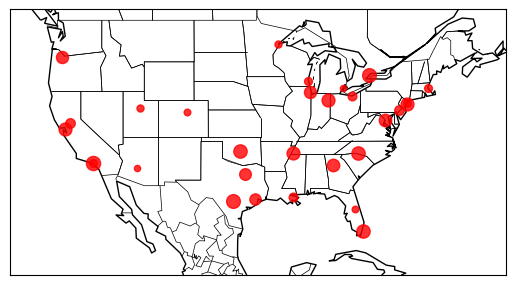

In [23]:
viz_team_counts(2014)